In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import u_momentum, v_momentum, get_rhs, get_coeff_mat, pressure_correct, update_velocity, check_divergence_free
import scipy.sparse as sparse
from qiskit.circuit.library import TwoLocal,RealAmplitudes
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.primitives import Estimator,Sampler
from qiskit_aer.primitives import Estimator as Aer_Estimator
from qiskit_aer.primitives import Sampler as Aer_Sampler
from qiskit import Aer, transpile
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.optimizers import *
from qiskit.quantum_info.operators import Operator, SparsePauliOp
from qiskit.opflow import PauliSumOp
from qiskit.providers import Options
import time
import dill as pickle
from qiskit import QuantumCircuit

n = 2
imax = 2**n                       # grid size in x-direction
jmax = imax                       # grid size in y-direction
max_iteration = 100             # iterations
max_res = 1000                   # initial residual
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
Re = 100                         # Reynolds number
mu = 1/Re                        # kinematic viscosity = 1/Reynolds number
dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = 1 / (jmax - 1)
x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
y = np.arange(0, 1+dy/2, dy)
alpha_p = 0.1                    # pressure under-relaxation
alpha_u = 0.7                    # velocity under-relaxation
tol = 1e-3                      # tolerance for convergence

### Main Algorithm

In [3]:
res_hist = []
quantum = True
iteration = 1
max_iteration = 100
max_res = 1000                   # initial residual
try:
    store_quantum
except:
    store_quantum = {}
try:
    store_classical
except:
    print("Run classical runs before quantum for comparison.")
    store_classical = {}
# Variable declaration
p = np.zeros((imax, jmax))             # p = Pressure
p_star = np.zeros((imax, jmax))        # intermediate pressure
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # right hand side vector of pressure correction equation
div = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))    # intermediate velocity
v = np.zeros((imax, jmax + 1))         # final velocity
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))    # intermediate velocity
u = np.zeros((imax + 1, jmax))         # final velocity
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient

# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

while iteration <= max_iteration and max_res > tol:
    iteration += 1
    
    # Solve u and v momentum equations for intermediate velocity 
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix 
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    
    # Form the Pressure Poisson coefficient matrix 
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    
    if quantum:
        b = rhsp/np.linalg.norm(rhsp)
        #def pressure_correct_quantum(imax, jmax, rhsp, Ap, p, alpha):
        Aps = sparse.csc_matrix(Ap)
        outer_b = sparse.vstack(b) * sparse.vstack(b).T
        num_qubits = int(np.log2(imax*jmax))
        H_test = Aps.T @ (sparse.eye(imax*jmax)-outer_b) @ Aps
        m_op = Operator(H_test.toarray())
        prep_circ = QuantumCircuit(num_qubits)
        for qubit in range(num_qubits):
            prep_circ.h(qubit)
        # sp_op_grouped = SparsePauliOp.from_operator(m_op).group_commuting(qubit_wise=True)
        # Solve pressure correction implicitly and update pressure
        optimizer = L_BFGS_B()
        #optimizer = COBYLA(maxiter=300,rhobeg=0.1,tol=1e-9)
        #optimizer = SLSQP(maxiter=4000,ftol=1e-12,eps=1e-12,tol=1e-12)
        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
                counts.append(eval_count)
                values.append(mean)
        est = Aer_Estimator(run_options={"shots": None},approximation = True)
        ansatz = RealAmplitudes(num_qubits,reps=num_qubits-1,initial_state=prep_circ)
        if iteration == 2:
         #    ip = [ 5.73516507e-02, -1.25213621e-01,  1.92531607e-02, -2.12927905e-01,
         # 3.78019588e-01,  2.80904246e-01,  1.12394067e-01,  5.89509731e-01,
         # 3.88551848e-01,  1.47919771e-01,  4.74469993e-01,  6.50281272e-01,
         # 9.42215883e-02,  4.75599461e-01,  5.23469621e-01,  1.47084930e+00,
         # 8.29287549e-01,  7.78328840e-01,  2.80223804e-04, -3.85251768e-01,
         # 4.61320686e-01,  2.25465734e-01,  1.92891187e-01,  1.60186704e-01,
         # 3.01712111e-01,  2.44732229e-02,  6.42330017e-01,  5.11188919e-02,
         # 6.50956376e-02, -1.11005197e-01,  3.64520731e-01,  7.71645240e-01,
         # 1.98819600e-01,  2.34282182e-01,  3.32107261e-02, -1.33570184e-02,
         # 1.00867381e+00,  7.49933404e-01,  4.20691675e-01, -1.84788767e-01,
         # 9.84603429e-02,  1.70014736e-01]
            #ip = store_quantum[2]['opt_params']
            ip = np.random.rand(ansatz.num_parameters)
        else:
            ip = result_sim.optimal_point
        eig = 1
        inner_it = 1
        while eig > 1e-4 and inner_it < 10:
            vqe = VQE(est,ansatz,optimizer,initial_point=ip)
            beg = time.time()
            result_sim = vqe.compute_minimum_eigenvalue(SparsePauliOp.from_operator(m_op))
            vqe_run = time.time()-beg
            eig = result_sim.eigenvalue
            inner_it += 1
            if inner_it > 1:
                ip = np.random.rand(ansatz.num_parameters)
        
        if result_sim.eigenvalue > 0.1:
            print("Warning: Eigenvalue from VQE is not near ground state. Eigenvalue is ",result_sim.eigenvalue)
        opt_circ = result_sim.optimal_circuit.bind_parameters(result_sim.optimal_point)
        opt_circ = transpile(opt_circ,basis_gates=['u','cx'],optimization_level=0)        
        backend = Aer.get_backend('statevector_simulator')
        vqes = backend.run(opt_circ)
        res = vqes.result()
        
        # p_prime_interior = res.get_statevector().data.real
        def rescale_sol(A,p,b):
            rescale = A @ p
            nzs = rescale.nonzero()[0]
            nzs2 = b.nonzero()[0]
            nzset = np.intersect1d(nzs,nzs2)
            rand_element = np.random.choice(nzset)
            scale_factor = b[rand_element]/rescale[rand_element]
            return scale_factor
        
        # result_sim = NumPyMinimumEigensolver().compute_minimum_eigenvalue(m_op)
        # p_prime_interior = result_sim.eigenstate.data.real
        p_prime_interior = res.get_statevector().data.real
        p_prime_interior = rescale_sol(Aps,p_prime_interior,b)*p_prime_interior*np.linalg.norm(rhsp)

        # if sum(p_prime_interior) < 0 :
        #     p_prime_interior = -1*p_prime_interior
        #     print("Warning: Corrected an assumed global phase")
        pressure = np.copy(p_star)  # Initial pressure
        p_prime = np.zeros((imax, jmax))  # Pressure correction matrix
        alpha = alpha_p
        z = 0  # Adjusted the indexing to start from 0
        for j in range(jmax):
            for i in range(imax):
                p_prime[i, j] = p_prime_interior[z]
                z += 1
                pressure[i, j] = p[i, j] + alpha * p_prime[i, j]
    
        pressure[0, 0] = 0  # Set the pressure at the first node to zero
            #return pressure, p_prime
        #p, p_prime = pressure_correct_quantum(imax, jmax, rhsp, Ap, p_star, alpha_p)
        p, p_prime = pressure, p_prime
        
        store_quantum.update({iteration:{
            'eig_val':result_sim.eigenvalue,            
            'opt_params':result_sim.optimal_point,
            'full_result': result_sim}})
        print("Iteration: ", iteration,"with VQE duration", vqe_run, " found eigenvalue:",result_sim.eigenvalue,
              "Norm difference from classical solution:",np.linalg.norm(p -store_classical[iteration]['sol_p']))
    else:
        p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)
        store_classical.update({iteration:{'sol_p':p,'max_res':max_res}})
    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    
    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence  
    if (iteration % 50) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
    
    # if max_res > 2:
    #     print("not going to converge!")
    #     break

Iteration:  2 with VQE duration 16.76867389678955  found eigenvalue: 1.111121361585532e-09 Norm difference from classical solution: 4.086517490402146e-07
Iteration:  3 with VQE duration 6.993038654327393  found eigenvalue: 5.913346395880481e-09 Norm difference from classical solution: 0.00015066021989228943
Iteration:  4 with VQE duration 6.701291084289551  found eigenvalue: 6.471605196178842e-10 Norm difference from classical solution: 0.00011863176732453832
Iteration:  5 with VQE duration 4.328211307525635  found eigenvalue: 1.2296019572949346e-05 Norm difference from classical solution: 6.259371016797463e-05
Iteration:  6 with VQE duration 2.972515821456909  found eigenvalue: 2.2257585319845896e-05 Norm difference from classical solution: 5.818713703074545e-05
Iteration:  7 with VQE duration 3.7805898189544678  found eigenvalue: 8.97619662042215e-06 Norm difference from classical solution: 8.305670091163712e-05
Iteration:  8 with VQE duration 3.433414936065674  found eigenvalue: 1.6

In [4]:
pickle.dump(store_quantum,open('data/4x4_quantum_100_steps_depth_3.p','wb'))

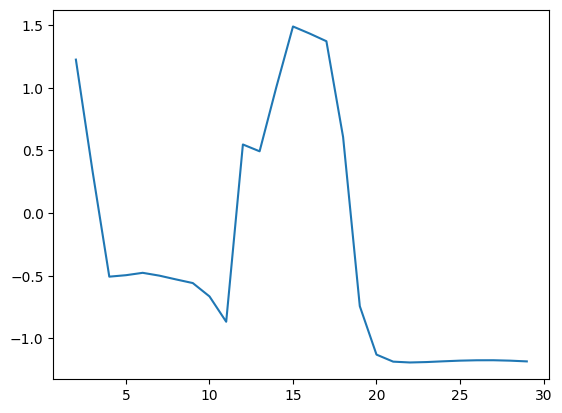

In [13]:
plt.plot([i for i in range(2,len(store_quantum))],[store_quantum[i]['full_result'].optimal_point[0] for i in range(2,len(store_quantum))])

### Visualization

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

Final Iteration = 31; Residual = 0.0009530998530748042


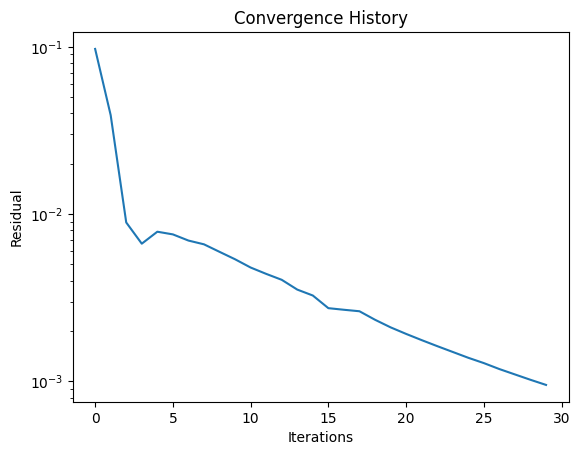

In [14]:
# Final residual        
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.plot(np.arange(iteration)[0:-1], res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence History")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

Ap Matrix Condition Number =  88.74780539102956


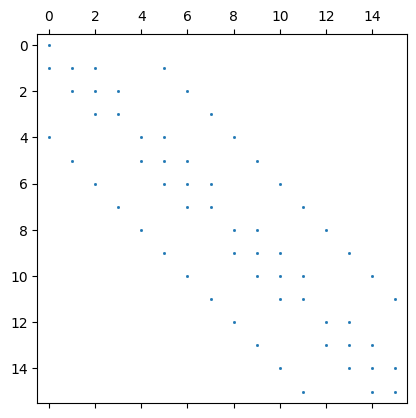

In [6]:
# Check sparse pattern
print("Ap Matrix Condition Number = ", np.linalg.cond(Ap))
plt.spy(Ap[0:64, 0:64], markersize=1)
plt.show()

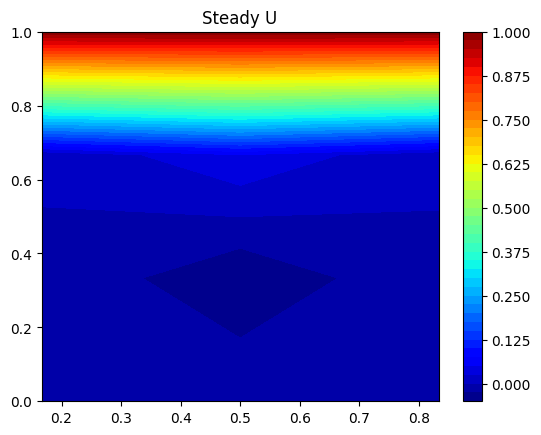

In [8]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

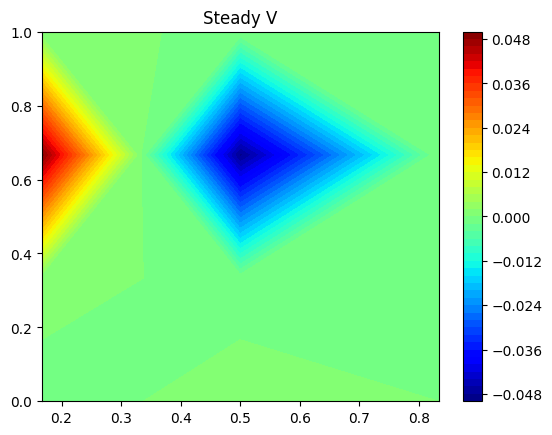

In [9]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, v[1:imax, 0:jmax].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady V")
plt.show()

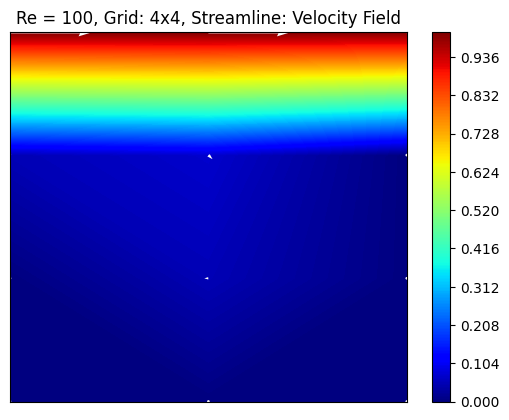

In [10]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 300, cmap='jet')
plt.colorbar()
# skip = (slice(None, None, 2), slice(None, None, 2))
plt.quiver(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, color='w')
plt.title('Re = {0}, Grid: {1}x{2}, Streamline: Velocity Field'.format(Re, imax, jmax))
plt.xticks([])
plt.yticks([])
plt.savefig("./Benchmark/Re{0}/Stream_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)
plt.show()

/home/bgard3/anaconda3/envs/CFD/lib/python3.8/site-packages/matplotlib/patches.py:3331: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


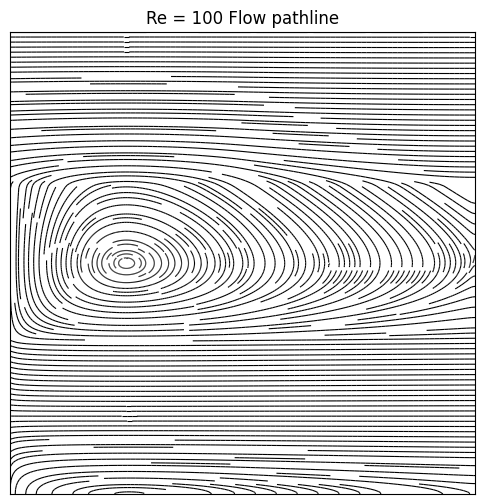

In [11]:
plt.figure(figsize=(6,6))
X, Y = np.meshgrid(x, y)
plt.streamplot(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, density=3, linewidth=0.8, arrowsize=0., color='k')
plt.title("Re = {0} Flow pathline".format(Re))
plt.xticks([])
plt.yticks([])
plt.show()

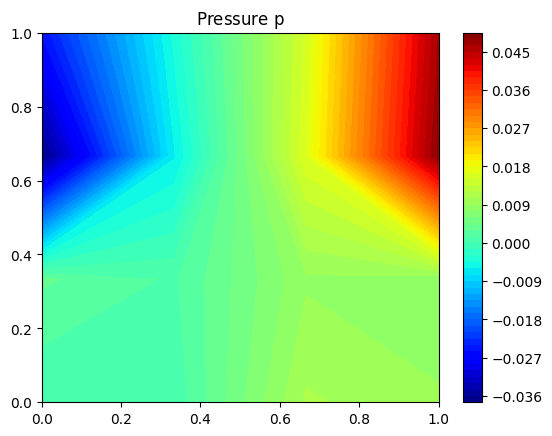

In [12]:
X, Y = np.meshgrid(y, y)
plt.figure()
plt.contourf(X, Y, p.T, 80, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title('Pressure $p$')
plt.savefig("./Benchmark/Re{0}/Stream_Re{0}_Grid{1}x{2}_pressure_p2.png".format(Re, imax, jmax), dpi=500)
plt.show()

### Benchmark with literature data

Ghia, U. K. N. G., Kirti N. Ghia, and C. T. Shin. "High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method." Journal of computational physics 48.3 (1982): 387-411.

In [12]:
GhiaU = np.loadtxt('./Benchmark/GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./Benchmark/GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [13]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./Benchmark/GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

#### Re = 100

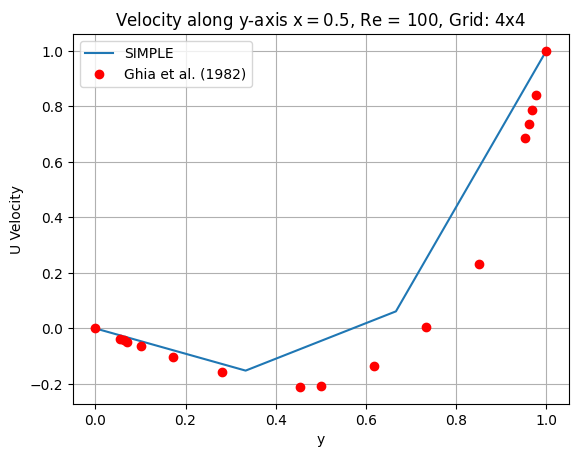

In [14]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

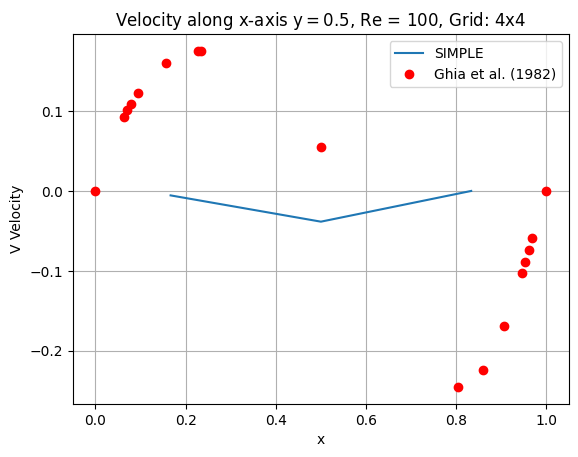

In [15]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 1], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/VBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

#### Re = 400

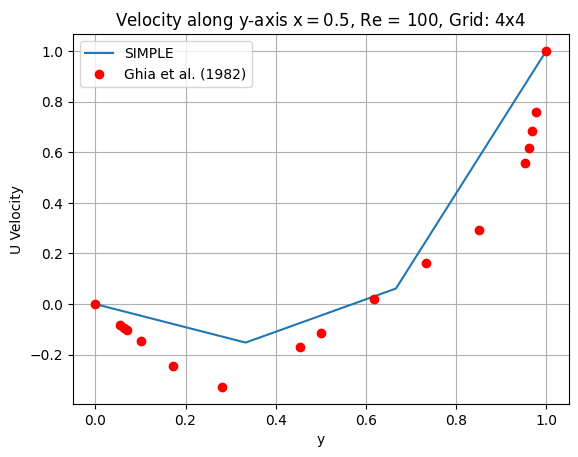

In [16]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/UBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)

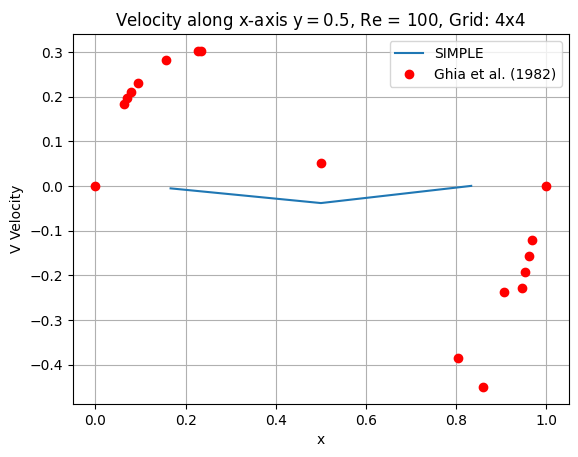

In [17]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 2], 'ro', label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()
plt.savefig("./Benchmark/Re{0}/VBench_Re{0}_Grid{1}x{2}.png".format(Re, imax, jmax), dpi=500)